# 프로젝트: 인물 모드 문제점 찾기
---
이 전까지 진행했던 인물모드 사진 만들기 예제를 참고하여 각각의 케이스 별 인물 사진을 만들어보고, 그 결과에 대한 문제점과 해결방안을 제시하는 프로젝트를 진행한다.  
* 예제와 다른 사진으로 아웃포커싱 사진 만들기
* 동물 사진을 이용하여 아웃포커싱 사진 만들기
* 인물 사진을 이용하여 배경 합성하기

## 개요
deeplabv3 모델을 이용하여 각 이미지 별 객체를 구분하고, 특정 객체가 두드러지게 나머지 객체를 블러처리하여 인물 사진 모드와 같이 이미지를 생성한다.  
생성한 이미지를 분석하고 deeplabv3 모델의 문제점을 파악한 후, 발견한 문제점을 해결할 수 있는 방법을 학습해본다.  

<br>

## 목차
1. 이미지 불러오기
    * 필요한 라이브러리 불러오기
    * 이미지가 저장된 경로에서 이미지 불러오기
2. 모델 불러오기
    * url을 통해 모델을 다운로드하고, 저장된 모델 불러오기
3. 이미지 분류하기
    * 레이블 지정
    * 이미지의 각 객체 별 레이블 확인
    * 이미지의 각 객체 별 컬러맵 지정
    * 배경과 피사체 분류
4. 결과물 출력
    * 인물 사진 모드 재현
    * 배경 합성
5. 문제점 파악
    * deeplabv3 모델을 사용했을 때에 발생하는 문제점 확인
    * 결과물에서의 문제점 확인
6. 솔루션 제시
    * 문제점을 해결하기 위한 솔루션 제시

### 이미지 불러오기
---
#### 필요한 라이브러리 불러오기
프로젝트에 필요한 라이브러리를 import하고, 버전 호환 문제가 발생할 염려가 있는 라이브러리들의 버전을 사전에 확인한다.

In [1]:
# 필요한 라이브러리 import
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from importlib.metadata import version
import pixellib

# 향 후, 버전 충돌 가능성이 있는 라이브러리 버전 확인
print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


#### 이미지가 저장된 경로에서 이미지 불러오기
이미지 파일이 저장된 경로에 접근하여 인물 사진, 동물 사진, 합성에 사용할 인물 사진과 합성에 사용할 배격 사진을 불러온다.

In [2]:
# 이미지가 저장되어 있는 디렉터리 경로 지정
file_path = os.getenv('HOME') + '/aiffel/human_segmentation/images'

# 이미지 경로 지정 함수 정의
def get_image_path(img_name):
    img_path = os.path.join(file_path, img_name + '.jpg')
    
    return img_path

# 이미지 로드 함수 정의
def load_image(path):
    return cv2.imread(path)

# 사람, 동물, 배경 합성 이미지 경로 지정 함수 호출
img_human_path = get_image_path('human_alone')
img_animal_path = get_image_path('animals')
img_chromakey_fg_path = get_image_path('to_change_bg')
img_chromakey_bg_path = get_image_path('background')

# 사람, 동물, 배경 합성 이미지 로드 함수 호출
load_human = load_image(img_human_path)
load_animal = load_image(img_animal_path)
load_chromakey_fg = load_image(img_chromakey_fg_path)
load_chromakey_bg = load_image(img_chromakey_bg_path)

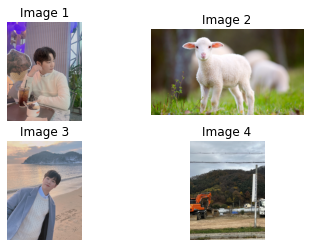

In [3]:
# 이미지 확인을 위해 로드된 이미지로 리스트 생성
images = [load_human, load_animal, load_chromakey_fg, load_chromakey_bg]

for i, img in enumerate(images):
    plt.subplot(2, 2, i+1)
    # OpenCV는 BGR 순서, Matplotlib은 RGB 순서이므로 변환
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
plt.show()

* 프로젝트에 사용될 이미지가 정상적으로 로드된 것을 확인할 수 있다.
* OpenCV의 이미지 색상표는 RGB가 아닌 BGR이기 때문에 Matplotlib으로 이미지를 시각화할 때에는 색상표의 순서를 RGB로 변환하는 작업이 필요하다.

### 모델 불러오기
---
#### url을 통해 모델을 다운로드하고, 저장된 모델 불러오기
깃허브 저장소에 접근하여 deeplabv3 모델을 다운로드하고, 저장된 경로에서 모델을 불러오는 작업을 진행한다.

In [4]:
# 저장할 모델 경로 지정
model_dir = os.getenv('HOME')+ '/aiffel/human_segmentation/models'
# 저장할 모델 이름 지정
model_file = os.path.join(model_dir,'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# 모델 다운로드 url 지정
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 모델 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fb32e49d550>)

/aiffel/aiffel/human_segmentation/models/ 경로에 모델이 정상적으로 저장된 것을 확인할 수 있다.

In [5]:
# 모델 객체 생성
model = semantic_segmentation()
# 다운로드한 모델 로드
model.load_pascalvoc_model(model_file)

### 이미지 분류하기
---
#### 레이블 지정
레이블 지정을 위해 이미지를 객체별로 분할하고, 분할 출력의 배열을 가져오는 작업을 진행한다.

In [6]:
# 사람 이미지 분할
segvalues_human, output_human = model.segmentAsPascalvoc(img_human_path)
# 동물 이미지 분할
segvalues_animal, output_animal = model.segmentAsPascalvoc(img_animal_path)
# 크로마키 포그라운드 이미지 분할
segvalues_chromakey_fg, output_chromakey_fg = model.segmentAsPascalvoc(img_chromakey_fg_path)
# 크로마키 백그라운드 이미지 분할
segvalues_chromakey_bg, output_chromakey_bg = model.segmentAsPascalvoc(img_chromakey_bg_path)

In [7]:
# 레이블 정의
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
# 레이블 길이 확인
len(LABEL_NAMES)

21

* 레이블의 종류는 배경, 비행기, 자전거 등 총 21개로 지정한다.

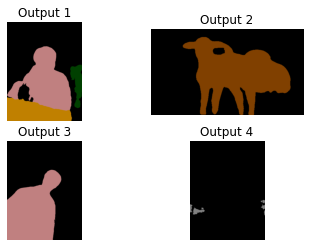

In [8]:
# output 이미지 확인을 위한 리스트 정의
outputs = [output_human, output_animal, output_chromakey_fg, output_chromakey_bg]

for i, img in enumerate(outputs):
    plt.subplot(2, 2, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Output {i+1}')
    plt.axis('off')
    
plt.show()

* 각 이미지가 몇 가지의 객체로 분할이 됐는지 확인할 수 있다.
> Output1은 4가지 객체로 나머지 이미지는 2가지 객체로 분할이 됐다.

#### 이미지의 각 객체 별 레이블 확인
이미지를 분할하여 얻은 데이터를 이용하여 각 이미지가 가지고 있는 객체의 종류를 확인한다.

In [9]:
# 분할 출력의 배열 확인을 위한 리스트 정의
segvalues = [segvalues_human, segvalues_animal, segvalues_chromakey_fg, segvalues_chromakey_bg]

# 각 이미지 별 분할 출력의 배열 확인
for i, values in enumerate(segvalues):
    print(f'{i+1}: {values}')
    print('\n')

1: {'class_ids': array([ 0, 11, 15, 16]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])}


2: {'class_ids': array([ 0, 17]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}


3: {'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,

* 분할 출력 배열에는 class_ids와 masks라는 key값이 있고, 이 중 class_ids의 values값을 통해 각 이미지가 어떤 객체를 담고 있는지 확인할 수 있다.

In [10]:
# 각 이미지 별 포함하고 있는 레이블 값 확인
for i, values in enumerate(segvalues):
    for class_id in values['class_ids']:
        print(LABEL_NAMES[class_id])
    print('\n')

background
diningtable
person
pottedplant


background
sheep


background
person


background
car




* 첫 번째 이미지는 배경, 탁자, 사람, 화분의 총 4개 객체를 포함하고 있다는 것을 확인할 수 있다.
* 두 번째 이미지: 배경, 양 객체의 총 2개 객체를 포함하고 있다는 것을 확인할 수 있다. 
* 세 번째 이미지: 배경, 사람 객체의 총 2개 객체를 포함하고 있다는 것을 확인할 수 있다. 
* 네 번째 이미지: 배경, 자동차 객체의 총 2개 객체를 포함하고 있다는 것을 확인할 수 있다. 

#### 이미지의 각 객체 별 컬러맵 지정
레이블 별 컬러맵을 생성하여 이미지의 객체 별 컬러맵을 지정하는 작업을 진행한다.

In [11]:
# 256X3 크기의 정수형 빈 행렬 생성
colormap = np.zeros((256, 3), dtype = int)
# 256 크기의 1차원 정수형 벡터 생성
ind = np.arange(256, dtype = int)

# 각 레이블 별 0~255까지의 값을 가진 색상맵 생성
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

* 0~20까지 총 21개 레이블에 해당하는 RGB값을 가지고 있는 컬러맵을 생성했다.

In [12]:
# 5, 10, 15, 20번째 인덱스에 해당하는 색 확인
colormap[5], colormap[10], colormap[15], colormap[20]

(array([128,   0, 128]),
 array([ 64, 128,   0]),
 array([192, 128, 128]),
 array([  0,  64, 128]))

* 4가지 객체에 대한 컬러맵을 확인한다.

In [13]:
# 형식에 맞게 RGB에서 BGR로 변경
seg_human_color = (128, 0, 128)
seg_animal_color = (0, 128, 64)
seg_chromakey_fg_color = (128, 128, 192)
seg_chromakey_bg_color = (128, 64, 0)

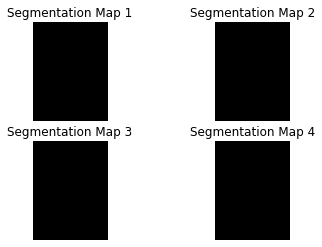

In [14]:
# 각 이미지 별 개체 색 지정을 위한 리스트 정의
seg_colors = [seg_human_color, seg_animal_color, seg_chromakey_fg_color, seg_chromakey_bg_color]

for i, color in enumerate(seg_colors):
    for output in outputs:
        seg_map = np.all(output==color, axis=-1)
        plt.subplot(2, 2, i+1)
        plt.imshow(seg_map, cmap='gray')
        plt.title(f'Segmentation Map {i+1}')
        plt.axis('off')
    
plt.show()

* 컬러맵을 지정했더니 모두 새까만 색으로 시각화가 되었다.
> 결과가 위처럼 나온 것은 output과 color 값이 같지 않을 경우 가장 첫 번째 인덱스인 배경 RGB:(0, 0, 0)이 출력됐다는 것으로 확인된다.  
> 위에서 실수가 있었던 것이, 각 이미지에서 색을 지정할 객체에 대한 색을 임의의 인덱스로 지정할 것이 아니라 객체의 레이블 인덱스 값에 맞춰줘야 한다는 것이다.  
> 임의의 인덱스를 설정했기에 당연히 output과 color 값이 같지 않아 첫 번째 인덱스 값이 출력이 될 것이기 때문에 컬러맵의 인덱스를 올바르게 수정하는 작업을 진행하기로 한다.

In [15]:
# 15 - 사람 클래스, 17 - 양 클래스, 0 - 배경 클래스
colormap[15], colormap[17], colormap[15], colormap[0]

(array([192, 128, 128]),
 array([128,  64,   0]),
 array([192, 128, 128]),
 array([0, 0, 0]))

In [16]:
seg_human_color = (128, 128, 192)
seg_animal_color = (0, 64, 128)
seg_chromakey_fg_color = (128, 128, 192)
seg_chromakey_bg_color = (0, 0, 0)

In [17]:
seg_colors = [seg_human_color, seg_animal_color, seg_chromakey_fg_color, seg_chromakey_bg_color]

# output과 seg_color를 비교하여 그 값이 True이면 map 생성
for i, color in enumerate(seg_colors):
    for output in outputs:
        seg_map = np.all(output==color, axis=-1)
        if output == color:
            plt.subplot(2, 2, i+1)
            plt.imshow(seg_map, cmap='gray')
            plt.title(f'Segmentation Map {i+1}')
            plt.axis('off')
    
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

* 반복문 내에 조건문을 주는 과정에서 에러가 발생했다.
> 원인은 np.all에 대해 제대로 이해하지 못한 상태에서 반복문과 조건문을 사용한 것이다.  
> np.any()로 np.all()이 True를 반환하게 됐을 때의 조건을 수행하도록 수정한다.

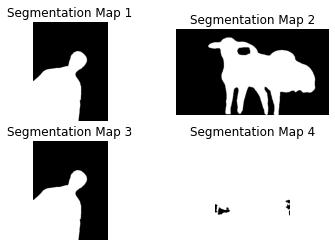

In [18]:
seg_colors = [seg_human_color, seg_animal_color, seg_chromakey_fg_color, seg_chromakey_bg_color]

for i, color in enumerate(seg_colors):
    for output in outputs:
        seg_map = np.all(output==color, axis=-1)
        if seg_map.any():
            plt.subplot(2, 2, i+1)
            plt.imshow(seg_map, cmap='gray')
            plt.title(f'Segmentation Map {i+1}')
            plt.axis('off')
    
plt.show()

* 에러는 잡았지만 첫 번째 이미지가 네 번째 이미지와 같은 데이터를 출력하는 현상이 발생했다.  
> 반복문의 흐름을 다시 그려보니, 이중 반복문을 수행하는 과정에서 세 번째 이미지의 사람 데이터와 맞물려 두 번째 사람 레이블로 업데이트가 된 상황으로 예상된다.  
> seg_map을 생성하는 반복문을 분리하여 다시 시각화를 진행하는 코드를 작성해보도록 한다.

In [19]:
seg_maps = []
for i in outputs:
    for j in seg_colors:
        seg_maps.append(np.all(outputs[i] == seg_colors[j], axis=-1))

for i, seg_map in enumerate(seg_maps):
    plt.subplot(2, 2, i+1)
    plt.imshow(seg_map, cmap='gray')
    plt.title(f'Segmentation Map {i+1}')
    plt.axis('off')
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

* 데이터와 인덱스와 차원 개념의 에러가 발생한 것 같다.
> 이렇게 되면 어설프게 반복문을 사용하기 보단 안전하게 각 이미지 별 seg_map을 생성하는 방향으로 전환이 필요할 것으로 판단된다.

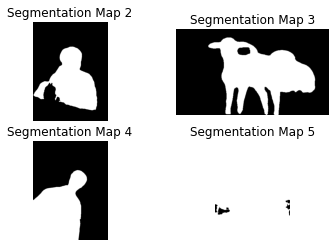

In [27]:
# 각 이미지의 output과 color map 값이 같을 경우
seg_human_map = np.all(outputs[0] == seg_colors[0], axis=-1)
seg_animal_map = np.all(outputs[1] == seg_colors[1], axis=-1)
seg_chromakey_fg_map = np.all(outputs[2] == seg_colors[2], axis=-1)
seg_chromakey_bg_map = np.all(outputs[3] == seg_colors[3], axis=-1)

# 흑백으로 객체를 확인하기 위한 리스트 생성
seg_maps = [seg_human_map, seg_animal_map, seg_chromakey_fg_map, seg_chromakey_bg_map]

i = 1
for seg_map in seg_maps:
    plt.subplot(2, 2, i)
    plt.imshow(seg_map, cmap='gray')
    plt.title(f'Segmentation Map {i+1}')
    plt.axis('off')
    
    i += 1
plt.show()

* 각 이미지 별로 seg_map을 생성하여 시각화를 진행했더니 정상적으로 출력이 된 것을 확인할 수 있다.  
* 시각적으로 확인했을 때에는 인물과 양 객체의 외곽선이 선명하게 구분이 된 것 같은데 실제로 이상 없이 구분이 됐는지 확인해보도록 한다.

#### 배경과 피사체 분리
배경 객체와 피사체를 분리하여 배경 객체에만 블러를 적용하여 다시 합치는 방식으로 인물 모드를 구현하여 본다.

In [28]:
# 원본 이미지 복제
img_human_show = load_human.copy()
img_animal_show = load_animal.copy()
img_chromakey_fg_show = load_chromakey_fg.copy()
img_chromakey_bg_show = load_chromakey_bg.copy()

# 이미지 마스크 생성
img_human_mask = seg_human_map.astype(np.uint8)*255
img_animal_mask = seg_animal_map.astype(np.uint8)*255
img_chromakey_fg_mask = seg_chromakey_fg_map.astype(np.uint8)*255
img_chromakey_bg_mask = seg_chromakey_bg_map.astype(np.uint8)*255

# 이미지 컬러 마스크 생성
color_human_mask = cv2.applyColorMap(img_human_mask, cv2.COLORMAP_JET)
color_animal_mask = cv2.applyColorMap(img_animal_mask, cv2.COLORMAP_JET)
color_chromakey_fg_mask = cv2.applyColorMap(img_chromakey_fg_mask, cv2.COLORMAP_JET)
color_chromakey_bg_mask = cv2.applyColorMap(img_chromakey_bg_mask, cv2.COLORMAP_JET)

#원본 이미지와 마스크 합성
img_human_show = cv2.addWeighted(img_human_show, 0.6, color_human_mask, 0.4, 0.0)
img_animal_show = cv2.addWeighted(img_animal_show, 0.6, color_animal_mask, 0.4, 0.0)
img_chromakey_fg_show = cv2.addWeighted(img_chromakey_fg_show, 0.6, color_chromakey_fg_mask, 0.4, 0.0)
img_chromakey_bg_show = cv2.addWeighted(img_chromakey_bg_show, 0.6, color_chromakey_bg_mask, 0.4, 0.0)

* addWeighted 메서드를 사용하여 원본 이미지와 컬러 마스크를 6:4 비율로 합성하여 실제로 컬러맵이 원본과 겹치는 영역을 확인한다.

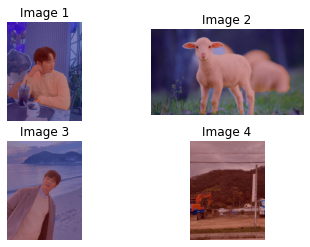

In [29]:
# 이미지 확인을 위한 리스트 생성
img_show = [img_human_show, img_animal_show, img_chromakey_fg_show, img_chromakey_bg_show]

for i, value in enumerate(img_show):
    plt.subplot(2, 2, i+1)
    plt.imshow(cv2.cvtColor(value, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {i+1}')
    plt.axis('off')
plt.show()

* 첫 번째 이미지의 오른쪽 팔꿈지 부분, 양의 왼쪽 귀 밑 등 어색한 부분이 확인된다. 이 문제에 대해서는 뒤에서 다시 다루기로 한다.

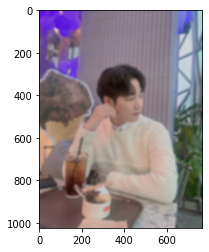

In [30]:
# 사람 이미지 블러 처리
img_human_blur = cv2.blur(load_human, (13, 13))
# 동물 이비지 블러 처리
img_animal_blur = cv2.blur(load_animal, (13, 13))

# 이미지 한 개 블러 처리 확인
plt.imshow(cv2.cvtColor(img_human_blur, cv2.COLOR_BGR2RGB))
plt.show()

* 이미지 전체에 대해 정상적으로 블러 처리된 것을 확인할 수 있다.

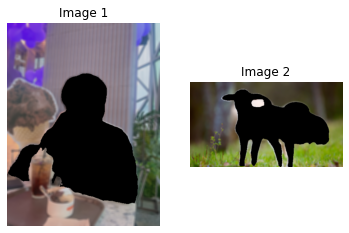

In [31]:
# 이미지 색상 채널 변환
img_human_mask_color = cv2.cvtColor(img_human_mask, cv2.COLOR_GRAY2BGR)
img_animal_mask_color = cv2.cvtColor(img_animal_mask, cv2.COLOR_GRAY2BGR)
# 배경과 피사체 필셀값 반전
img_human_bg_mask = cv2.bitwise_not(img_human_mask_color)
img_animal_bg_mask = cv2.bitwise_not(img_animal_mask_color)
# 피사체 0으로 만들고 배경만 남기기
img_human_bg_blur = cv2.bitwise_and(img_human_blur, img_human_bg_mask)
img_animal_bg_blur = cv2.bitwise_and(img_animal_blur, img_animal_bg_mask)

bg_blurs = [img_human_bg_blur, img_animal_bg_blur]

for i, blur in enumerate(bg_blurs):
    plt.subplot(1, 2, i+1)
    plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {i+1}')
    plt.axis('off')
plt.show()

* 피사체와 피사체가 아닌 것의 픽셀 값을 반전시켜서 배경에 대한 데이터만 추출한다.

### 결과물 출력
---
#### 인물 사진 모드 재현
사람 이미지와 동물 이미지로 아이폰의 인물 사진 모드를 재현한다.

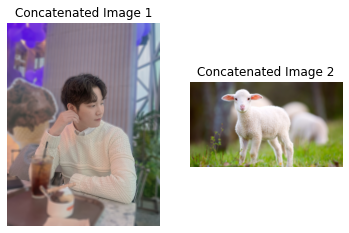

In [32]:
# 원본 이미지와 블러 처리된 배경 합치기
img_human_concat = np.where(img_human_mask_color==255, load_human, img_human_bg_blur)
img_animal_concat = np.where(img_animal_mask_color==255, load_animal, img_animal_bg_blur)

img_concats = [img_human_concat, img_animal_concat]

for i, img_concat in enumerate(img_concats):
    plt.subplot(1, 2, i+1)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.title(f'Concatenated Image {i+1}')
    plt.axis('off')
plt.show()

* 피사체는 선명하게, 배경은 흐리게 만드는 인물 사진 모드와 같이 아웃포커싱 이미지가 정상적으로 출력되었다.
* 위와 같은 출력이 된 단계는 다음과 같다.
    1. 이미지 블러 처리
    2. 피사체의 레이블로 구분하여 피사체와 배경을 255(피사체)와 0(배경)의 값으로 분리
    3. 피사체와 배경의 픽셀을 반전시켜서 피사체의 픽셀 값으로 0으로 변환
    4. bitwise_and 연산을 수행하여 피사체의 픽셀값은 그대로 0인 상태로 배경 이미지만 남기기
    5. 피사체의 픽셀값이 255인 마스크 이미지에서 픽셀값이 255인 부분은 선명한 이미지로, 그렇지 않은 부분에는 블러처리된 이미지로 치환하여 아웃포커싱 이미지 완성

#### 배경 합성
위에서 실시한 객체 분리 방법으로 피사체와 배경을 합성한 이미지를 생성한다. 

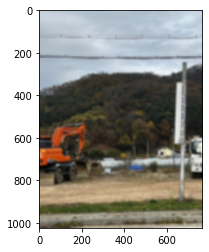

In [33]:
# 합성 배경 이미지 블러 처리
img_chromakey_bg_blur = cv2.blur(load_chromakey_bg, (13,13))

plt.imshow(cv2.cvtColor(img_chromakey_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

* 위에 출력된 이미지에서는 자동차라는 객체가 포함되어 있지만, 이미지 자체를 배경으로 사용할 것이기 때문에 통으로 블러 처리를 진행한다.

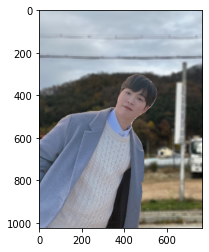

In [34]:
# 이미지 색상 채널 변환
img_chromakey_fg_mask_color = cv2.cvtColor(img_chromakey_fg_mask, cv2.COLOR_GRAY2BGR)

# 사람 이미지와 블러 처리된 별개의 배경 합성
img_concat = np.where(img_chromakey_fg_mask_color==255, load_chromakey_fg, img_chromakey_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

* 피사체가 될 이미지의 픽셀값을 255로 변환하는 작업을 거친 후, 인물 모드 사진 예제와 같이 픽셀 값을 조건으로 피사체와 배경을 치환하여 합성사진을 생성한다.

### 문제점 파악
---
#### deeplabv3 모델을 사용했을 때에 발생하는 문제점 확인
deeplabv3 모델을 사용하여 생성한 이미지에 어떠한 문제점이 있는지 확인해보도록 한다.

![image_problem](./images/img_problem1.png)

Image1에서 오른쪽 팔 부분이 실제로 사람 객체에 속한 부분이 아님에도 사람 객체라고 인식이 된 것을 확인할 수 있다.  
Image2에서 양의 왼쪽 귀 아래와 몸통 오른쪽 부분은 실제로 뒤에서 풀을 뜯고 있는 양인데도 불구하고 양 객체가 아니라고 인식이 된 것을 확인할 수 있다.  
Image3에서 코트 왼쪽 가장자리가 가위로 잘린 것처럼 사람 객체의 경계선을 제대로 인식하지 못한 것을 확인할 수 있다.  
Image4에서 포크레인과 트럭은 엄연한 자동차 객체임에도 불구하고 그 일부만 객체로 인식을 한 것을 확인할 수 있다.  

이렇듯 객체를 인식하는 인식률에서 살짝 아쉬운 성능을 보이고 있으며, 이와 같은 문제점을 정리하면 다음과 같다.
* 객체가 아닌 부분을 객체로 구분하는 문제
* 객체인 부분을 정확히 구분하지 못하는 문제
* 객체의 경계선을 제대로 구분하지 못하는 문제
* 객체 전체가 아닌 일부만 객체로 구분하는 문제

#### 결과물에서의 문제점 확인
위에서 출력한 결과물에서 지금까지 파악한 문제점이 보이는지 확인해보도록 한다.

<br> 

![image_problem](./images/img_problem2.png)
![image_problem](./images/img_problem3.png)

Conatenate Image1을 보면 위에서 확인한 객체가 아닌 부분을 객체로 인식하는 문제로 인해 해당 부분이 어색하게 생성된 것을 확인할 수 있다.  
Conatenate Image1의 경우 원본 이미지 자체가 이미 앞에서 카메라를 보고 있는 양을 기준으로 아웃포커싱이 되었기 때문에 육안으로 구분이 힘들지만 자세히 보면 바로 뒤에서 풀을 뜯고 있는 양임에도 불구하고 1번 상자의 블러 처리 정도가 2번 네모의 블러 처리보다 더 심한 것을 알 수 있다.  
마지막 사진을 보면 위에서 발견한 경계선 인식 문제와 같이 상자로 표시한 부분이 찢겨나간 것을 확인할 수 있다.

### 솔루션 제시
---
#### 문제 해결을 위한 솔루션 제시
지금까지 발견된 문제를 해결하기 위한 방법에는 무엇이 있는지 알아보고 그 방법의 메커니즘에 대해 설명한다.

* ensemble learning을 사용하여 semantic segmentation mask의 오류를 보완
    * ensemble learning 메커니즘: 각 모델은 이미지에 대한 예측을 생성하고 이러한 예측을 결합하여 더 정확한 예측을 생성한다.
        1. 동일한 모델을 여러 번 학습
        2. 서로 다른 모델을 학습
        3. 각 모델의 예측을 결합
        4. 각 모델의 예측을 평균 혹은 가중평균 구하기  
        
> 예를 들어, 이미지에 대한 세 가지 예측이 있다고 가정했을 때, 예측 1은 이미지의 절반을 사람으로 예측하고, 예측 2는 이미지의 절반을 자동차로 예측하고, 예측 3은 이미지의 절반을 나무로 예측한다. ensemble learning은 이러한 세 가지 예측을 결합하여 이미지의 절반을 사람으로, 절반을 나무로 예측하는 더 정확한 예측을 생성할 수 있다.

* post-processing을 사용하여 semantic segmentation mask의 오류를 보완
    * morphological operations: mask의 경계를 부드럽게 하거나, 연결되지 않은 영역을 연결
    * watershed algorithm: mask를 더 작은 영역으로 분할  
    
> 예측된 mask는 경계가 부정확하거나, 부분적으로 누락되거나, 잘못 분할되는 등 일반적으로 완벽하지 않을 수 있다. post-processing은 이러한 오류를 수정하여 예측된 mask를 개선할 수 있다.

* interactive segmentation을 사용하여 semantic segmentation mask의 오류를 보완
    * interactive segmentation 메커니즘: 사용자의 도움을 받아 mask를 수정하는 방법으로 사용자는 mask의 오류를 수정하거나, 새로운 mask를 생성한다.  
    
> 사용자는 마우스나 터치스크린을 사용하여 mask를 수정할 수 있다. 예를 들어, 사용자가 mask의 경계를 수정하거나, 잘못 분할된 영역을 병합할 수 있다.
> interactive segmentation은 가장 유연한 방법으로 사용자는 자신의 필요에 따라 mask를 수정할 수 있다. 하지만 사용자가 mask를 수정해야 하므로, 시간이 많이 소요될 수 있다.

## 회고

<br>

### SUMMARY
---
deeplabv3 모델을 사용하여 인물 사진에 대한 인물 모드 적용, 동물 사진에 대한 인물 모드 적용, 인물과 배경 합성 프로젝트를 진행했다.  
이미 학습이 되어있는 모델을 사용한만큼 상당히 양질의 결과물이 나왔지만 디테일한 부분을 파고 들었을 때 아쉬운 부분이 몇 가지 보여 그에 대한 분석과 솔루션을 함께 탐구를 진행했다.  

### KPT
---
#### KEEP
* 이미지가 변환되는 과정을 이해하며 프로젝트를 진행했다.
* 문제점에 대한 솔루션을 적극적으로 서칭했다.
#### PROBLEM
* 어렵고 복잡한 코드를 복붙했다.
* 코드를 이해하지 못한 상황에서 마음 급하게 작성하여 오류를 찾는 데에 시간이 걸렸다.
#### TRY
* 코드가 복잡하더라도 복붙보다는 직접 코딩을 하면서 이해를 하고 넘어가려고 노력을 해야겠다.
* 시간이 촉박하더라도 차분하게 코드를 이해하며 그 흐름을 파악하면서 학습한다.
* 찾아본 솔루션에 대해 더 깊게 분석하여 실제로 반영을 하면 어떤 결과가 출력되는지 확인한다.